# Web Scraping Into a MySQL Database 
# Project Steps:
1. Extract data using Fixer.io Currency API.
2. Transform the data into a relevant form.
3. Load the data into a MySQL Data-Warehouse.
4. Data Analysis/Visualization

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps
import pymysql
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.dates as md
sns.set_style('white')

## 1. Extract data using Fixer.io Currency API.

Will extract EUR/USD currency data for 2018-2020. More details of API usage at https://fixer.io/

In [2]:
# Generating a range of daily dates from 2018 to 2020

dates = pd.date_range(start='1/1/2018', end = '1/1/2021').to_pydatetime().tolist()

In [3]:
# Generating a dictionary where the keys are the days and the values are the currencies rates with a EUR base

data = {}
for date in range(0,len(dates)):
    url = 'http://api.exchangeratesapi.io/v1/'+dates[date].strftime("%Y-%m-%d")+'?access_key=6434612262013db648c8ec905e6e80f8'
    r = requests.get(url)
    html = r.text
    soup = BeautifulSoup(html)
    data[dates[date]] = soup

It's a good practice to have a backup for your data, especially when relying on external services. Better safe than sorry!

In [4]:
# Create backup data source

backupData = data.copy()

## 2. Transform data to relevant form

We need to extract the US Dollar rates against the EUR (EUR/USD). Fixer.io sends data in HTML format, which is a lengthy string in Python. I've utilized string manipulation to extract USD rates for each specified date and compiled them into a dictionary with dates as keys and rates as values.

In [5]:
EUR_USD_rates = {}

for day in range(len(dates)):
    # Extracting the HTML Data
    d = data[dates[day]].text
    
    # Extracting the Date from the Data
    start_date_location = d.find('"date":"') + len('"date":"')
    end_date_location = d.find('","rates"')
    date = d[start_date_location:end_date_location]
    
    # Extracting the Rate from the Data
    start_rate_location = d.find('"USD":') + len('"USD":')
    end_rate_location = d.find(',"UYU"')
    rate = float(d[start_rate_location:end_rate_location])
    
    # Creating a Dictionary where the keys are the dates and the values are the EUR/USD rates
    EUR_USD_rates[date] = rate

Creating back-up for data

In [6]:
# Creating a Backup for the Data
rates_backup_data = EUR_USD_rates.copy()

## 3. Load the data into a MySQL Data-Warehouse.

Before uploading the data to MySQL, I'll save it as a CSV file for future analysis. This ensures I have easy access for later evaluations.

In [45]:
# Creating a Panda's Dataframe out of the rates dictionary
df = pd.DataFrame.from_dict(EUR_USD_rates, orient='index', columns=['Rates'])

# Load data into a CSV file
df.to_csv('EUR_USD_Rates.csv')

In [10]:
# Import pymysql module
import pymysql

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',
                             db='mysql')
                             
cursor = connection.cursor()

Creating a table called “rates”

In [11]:
sql = "CREATE TABLE rates(day VARCHAR(50) NOT NULL, rate FLOAT NOT NULL)"

# Executing Query
cursor.execute(sql)

# Commit the Query
connection.commit()

In [13]:
df.head()

,Rates
2018-01-01,1.201496
2018-01-02,1.206713
2018-01-03,1.201492
2018-01-04,1.207300
2018-01-05,1.203219


To populate the table with my extracted data, I'll need some transformations to make it compatible with MySQL. Essentially, I'll convert the earlier-created dataframe into a tuple. Each row in this tuple will contain a 'date' column (String) and a 'rate' column (Float).

In [14]:
dates = df.index.values
rates = df.iloc[:,0].values
data_tuple = tuple(zip(dates, rates))

Inserting data

In [15]:
for data in range(len(data_tuple)):
    
    # Create a new record
    sql = "INSERT INTO rates (`day`, `rate`) VALUES (%s, %s)"
    
    # Execute the query
    cursor.execute(sql,data_tuple[data])
    
    
# Commit the transaction
connection.commit()

In [16]:
# Select All Rows from the Database
sql = "select * from rates"
cursor.execute(sql)

result = cursor.fetchall()
# Print the first 10 Rows
for i in result[0:10]:
    print(i)

('2018-01-01', 1.2015)
('2018-01-02', 1.20671)
('2018-01-03', 1.20149)
('2018-01-04', 1.2073)
('2018-01-05', 1.20322)
('2018-01-06', 1.20322)
('2018-01-07', 1.20409)
('2018-01-08', 1.19732)
('2018-01-09', 1.1933)
('2018-01-10', 1.19589)


## 4. Data Analysis/Visualization

In [17]:
# Loading data from the CSV file
df = pd.read_csv('EUR_USD_Rates.csv')

# Renaming the date column
df.rename({'Unnamed: 0':'day'},axis = 1, inplace=True)

# Generating simple descriptive statistics
df.describe()

,Rates
count,1097.000000
mean,1.147828
std,0.042580
min,1.065604
25%,1.115418
50%,1.137314
75%,1.176884
max,1.251405


### Analysis 

Over the past three years, the average USD to EUR exchange rate stands at 1.147. With a standard deviation that's just 4.2% of the mean, the data exhibits low volatility. 

The interquartile range further confirms this stability, showing that half of the values range from 1.115 to 1.176.

In [29]:
df

,day,Rates,month,year
0,2018-01-01,1.201496,1,1970
1,2018-01-02,1.206713,1,1970
2,2018-01-03,1.201492,1,1970
3,2018-01-04,1.207300,1,1970
4,2018-01-05,1.203219,1,1970
...,...,...,...,...
1092,2020-12-28,1.222193,1,1970
1093,2020-12-29,1.225257,1,1970
1094,2020-12-30,1.229975,1,1970
1095,2020-12-31,1.217875,1,1970


### Plot Trending rate

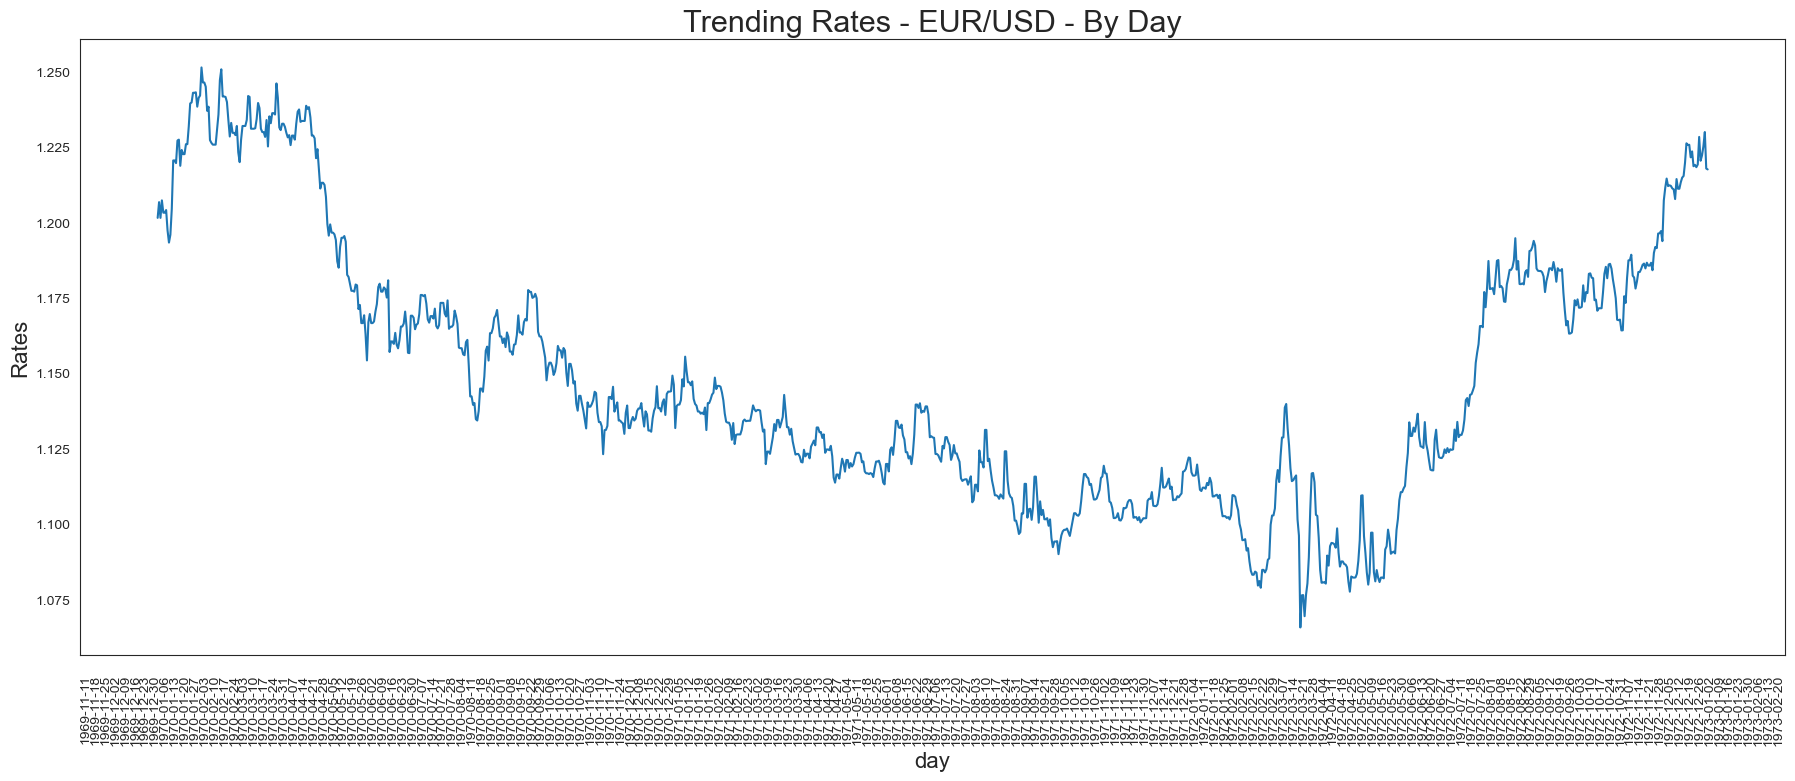

In [25]:
fig, ax = plt.subplots(figsize = [22,8])

# specify the position of the major ticks at the beginning of the week
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 1))
# specify the format of the labels as 'year-month-day'
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)

# specify the position of the minor ticks at each day
ax.xaxis.set_minor_locator(md.DayLocator(interval = 100))



ax.tick_params(axis = 'x', which = 'major', length = 10)
ax.tick_params(axis = 'x', which = 'minor', length = 5)

sns.lineplot(data=df, x = 'day', y = 'Rates', ax=ax)
plt.xlabel('day',size = 16)
plt.ylabel('Rates',size = 16)
plt.title('Trending Rates - EUR/USD - By Day',size = 22)
plt.show()

### Box Plot by Month



In [36]:
# Creating a Month column
df['month'] = pd.DatetimeIndex(df.day).month

# Creating a Year column
df['year'] = pd.DatetimeIndex(df.day).year

# Sample Data
df

,day,Rates,month,year
0,2018-01-01,1.201496,1,2018
1,2018-01-02,1.206713,1,2018
2,2018-01-03,1.201492,1,2018
3,2018-01-04,1.207300,1,2018
4,2018-01-05,1.203219,1,2018
...,...,...,...,...
1092,2020-12-28,1.222193,12,2020
1093,2020-12-29,1.225257,12,2020
1094,2020-12-30,1.229975,12,2020
1095,2020-12-31,1.217875,12,2020


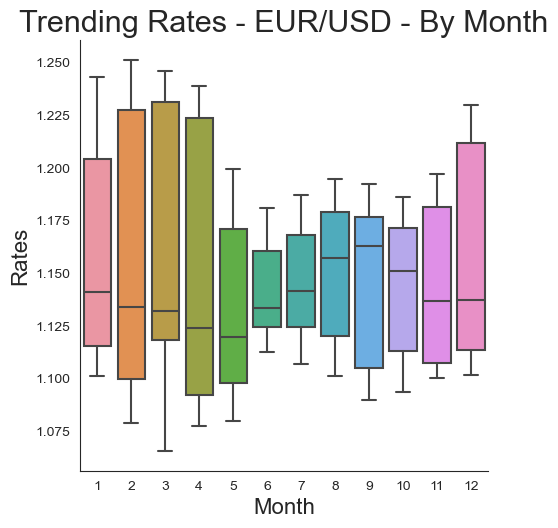

In [37]:
sns.catplot(data=df.reset_index(), x = 'month', y = 'Rates', kind = 'box')
plt.xlabel('Month',size = 16)
plt.ylabel('Rates',size = 16)
plt.title('Trending Rates - EUR/USD - By Month',size = 22)
plt.show()

### Point plot by Month

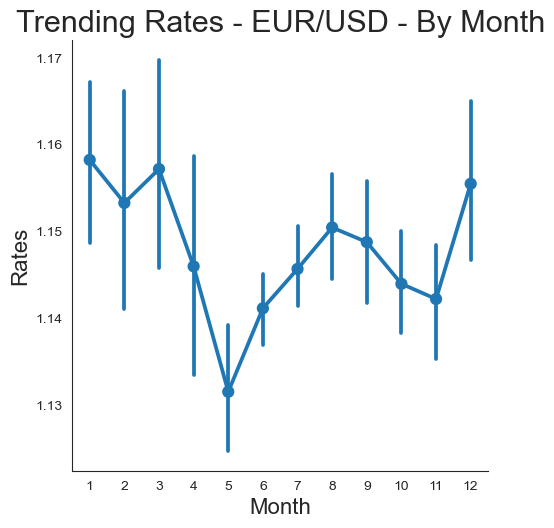

In [38]:
sns.catplot(data=df.reset_index(), x = 'month', y = 'Rates', kind = 'point')
plt.xlabel('Month',size = 16)
plt.ylabel('Rates',size = 16)
plt.title('Trending Rates - EUR/USD - By Month',size = 22)
plt.show()

### Trending Point Plot by Month/Year



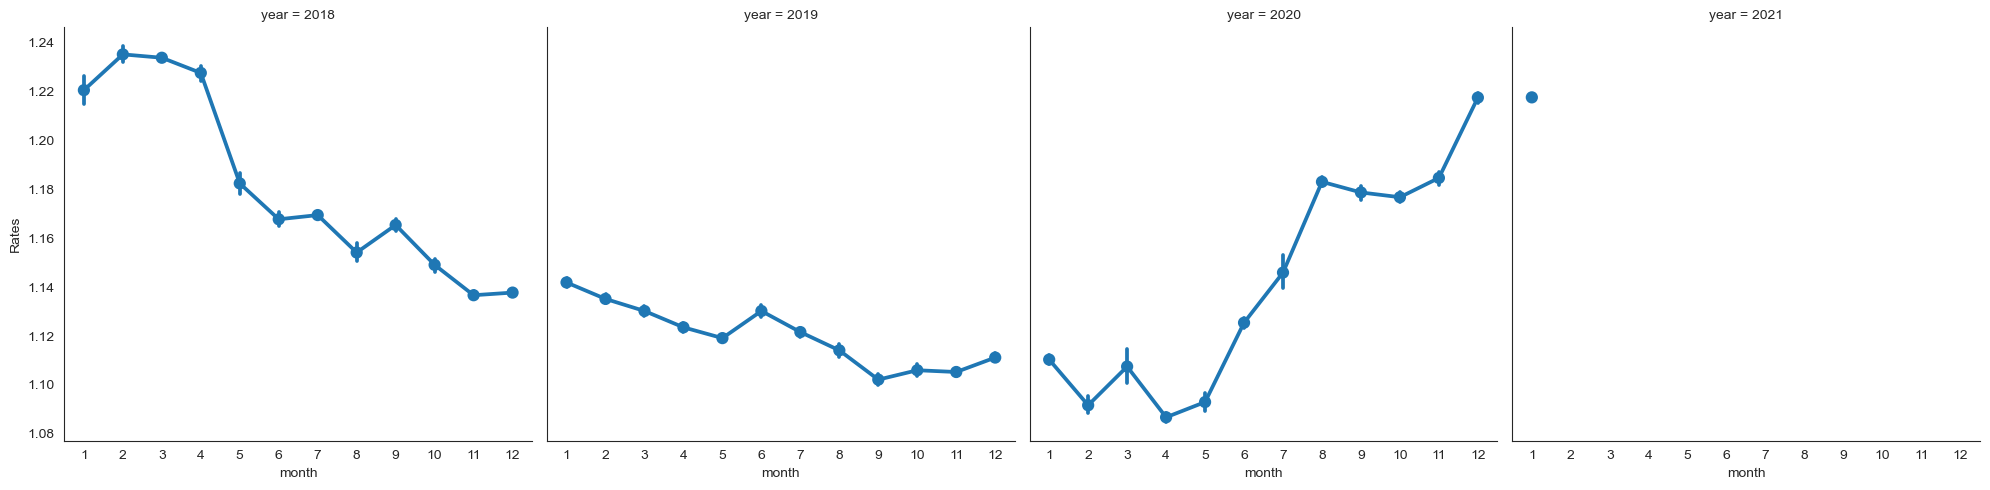

In [39]:
sns.catplot(data=df.reset_index(), x = 'month', y = 'Rates', kind = 'point',col = 'year')
plt.show()

### Density Plot by Month

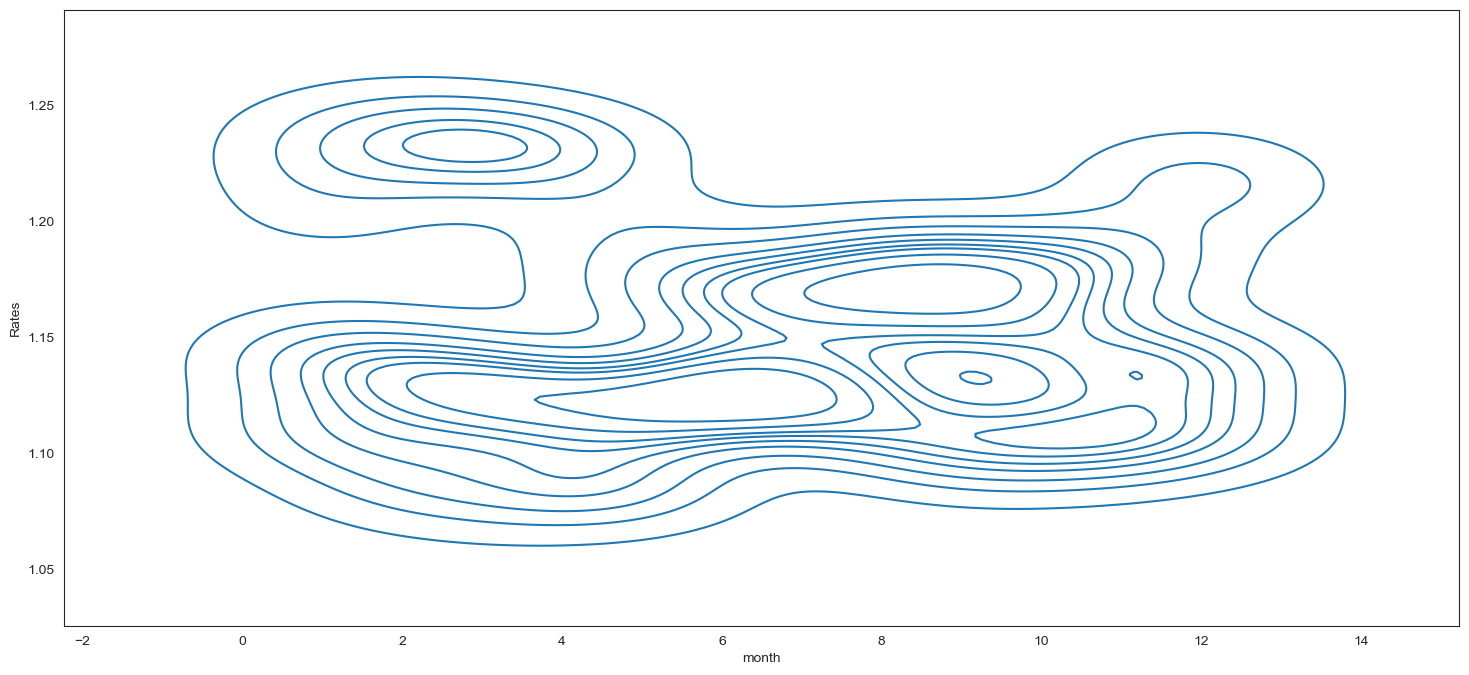

In [40]:
fig, ax = plt.subplots(figsize = [18,8])
sns.kdeplot(data = df, x = 'month', y = 'Rates')
plt.show()

### Kernel Density Plot — Comparison By Year

In [41]:
def sql(query):
    return ps.sqldf(query)

query1 = '''
select Rates 
from df
where year = 2018
'''

query2 = '''
select Rates 
from df
where year = 2019
'''

query3 = '''
select Rates 
from df
where year = 2020
'''

df_2018 = sql(query1)
df_2019 = sql(query2)
df_2020 = sql(query3)

/var/folders/f7/t51lvbwn6_xg2vbn66mndyq40000gn/T/ipykernel_68820/2105252631.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df_2018,x = 'Rates',shade = True, label='2018')
/var/folders/f7/t51lvbwn6_xg2vbn66mndyq40000gn/T/ipykernel_68820/2105252631.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df_2019,x = 'Rates',shade = True, label='2019')
/var/folders/f7/t51lvbwn6_xg2vbn66mndyq40000gn/T/ipykernel_68820/2105252631.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df_2020,x = 'Rates',shade = True, label='2020')


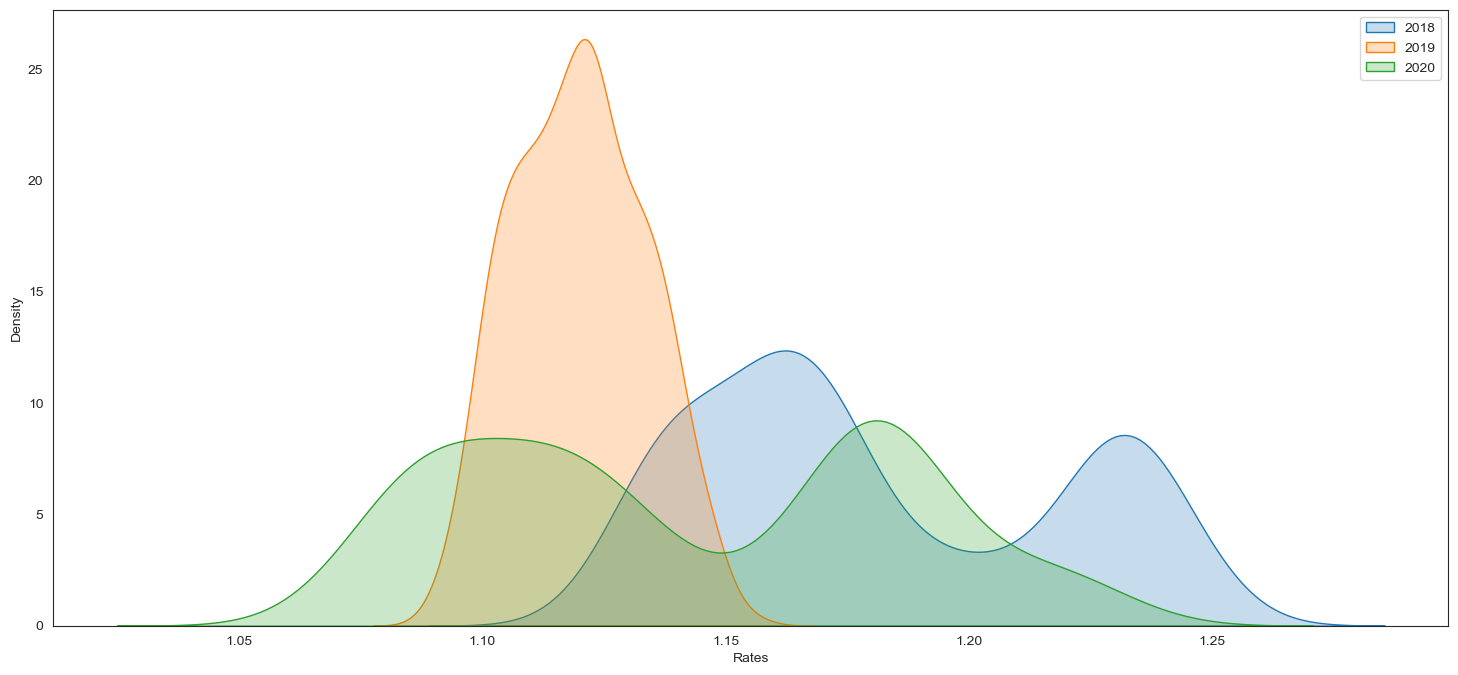

In [42]:
fig, ax = plt.subplots(figsize = [18,8])
sns.kdeplot(data = df_2018,x = 'Rates',shade = True, label='2018')
sns.kdeplot(data = df_2019,x = 'Rates',shade = True, label='2019')
sns.kdeplot(data = df_2020,x = 'Rates',shade = True, label='2020')
plt.legend()
plt.show()